In [1783]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt 
from sklearn.model_selection import cross_validate
from xgboost.sklearn import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm_notebook
from collections import Counter
from sklearn.metrics import roc_auc_score
import pickle
pd.set_option('display.max_columns', 500)

In [1788]:
train = pd.read_csv("train_users_2.csv")
test = pd.read_csv("test_users.csv")
countries = pd.read_csv("countries.csv")
sessions = pd.read_csv("sessions.csv")
age_gender = pd.read_csv("age_gender_bkts.csv")

In [1789]:
train['country_destination'].value_counts()/len(train)

NDF      0.583473
US       0.292226
other    0.047290
FR       0.023532
IT       0.013282
GB       0.010888
ES       0.010536
CA       0.006690
DE       0.004971
NL       0.003570
AU       0.002525
PT       0.001017
Name: country_destination, dtype: float64

In [1790]:
labels = train['country_destination'].values
labels

array(['NDF', 'NDF', 'US', ..., 'NDF', 'NDF', 'NDF'], dtype=object)

In [1791]:
train.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [1792]:
train1 = train.drop(['country_destination'], axis=1)

In [1793]:
length = len(train1)
test_id = test.id
all_data = pd.concat((train1, test), axis = 0, ignore_index = True)

In [1794]:
all_data = all_data.drop(['date_first_booking'], axis=1)

## Feature Engineering

In [1795]:
def replace_f(df,columns,threshold):
    dict_={}
    for i,j in dict(df[columns].value_counts()/len(df)).items():
        if j > threshold:
            dict_[i]=i
        else:
            dict_[i]='other'
    df[columns] = df[columns].map(dict_)

concat sessions

In [1796]:
replace_f(sessions,'action_detail',0.01)

In [1797]:
mean_sess = sessions.groupby(by=['user_id','action_detail']).mean().reset_index().pivot(index='user_id',columns='action_detail',values='secs_elapsed').reset_index()

In [1798]:
all_data = pd.merge(all_data, mean_sess, left_on='id', right_on ='user_id',how='left')

cut created date and first active

In [1799]:
all_data = all_data.drop(['id','user_id'], axis=1)

In [1800]:
all_data.head(1)

,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,-unknown-,change_trip_characteristics,dashboard,edit_profile,header_userpic,listing_reviews,message_thread,other,p3,similar_listings,update_listing,user_profile,user_social_connections,user_wishlists,view_search_results,wishlist_content_update
0,2010-06-28,20090319043255,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [1801]:
print(all_data.isnull().sum())

date_account_created                0
timestamp_first_active              0
gender                              0
age                            116866
signup_method                       0
signup_flow                         0
language                            0
affiliate_channel                   0
affiliate_provider                  0
first_affiliate_tracked          6085
signup_app                          0
first_device_type                   0
first_browser                       0
-unknown-                      167499
change_trip_characteristics    219481
dashboard                      222120
edit_profile                   255596
header_userpic                 181881
listing_reviews                247600
message_thread                 255518
other                          156510
p3                             180630
similar_listings               234196
update_listing                 243882
user_profile                   218008
user_social_connections        247700
user_wishlis

In [1802]:
all_data['active_year'] = all_data['timestamp_first_active'].astype(str).str.slice(0,4)
all_data['active_month'] = all_data['timestamp_first_active'].astype(str).str.slice(4,6)
all_data['active_day'] = all_data['timestamp_first_active'].astype(str).str.slice(6,8)
all_data = all_data.drop(['timestamp_first_active'], axis=1)

all_data['created_year'] = all_data['date_account_created'].astype(str).str.slice(0,4)
all_data['created_month'] = all_data['date_account_created'].astype(str).str.slice(5,7)
all_data['created_day'] = all_data['date_account_created'].astype(str).str.slice(8,10)
all_data = all_data.drop(['date_account_created'], axis=1)

age bining

In [1803]:
all_data.reset_index(inplace=True)

indexs=[]
def age_deal(row):
    if row['age'] < 200:
        return row['age']
    if row['age'] > 2000:
        indexs.append(row['index'])
        return row['age']
    if (row['age'] > 1000) and (row['age'] < 2000):
        date = row['created_year']
        age = float(date) - row['age']
        return age
    else:
        indexs.append(row['index'])
        return row['age']
all_data['bining'] = all_data.apply(age_deal, 1)

bins = [0] + list(range(20,101,5)) + [200]
label = list(range(1, len(bins)))
all_data['bining'] = pd.cut(all_data['bining'], bins=bins, labels=label)

In [1804]:
all_data = all_data.drop(columns=['index'])

In [1805]:
all_data.head()

,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,-unknown-,change_trip_characteristics,dashboard,edit_profile,header_userpic,listing_reviews,message_thread,other,p3,similar_listings,update_listing,user_profile,user_social_connections,user_wishlists,view_search_results,wishlist_content_update,active_year,active_month,active_day,created_year,created_month,created_day,bining
0,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2009,03,19,2010,06,28,NaN
1,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2009,05,23,2011,05,25,5
2,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2009,06,09,2010,09,28,9
3,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2009,10,31,2011,12,05,6
4,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2009,12,08,2010,09,14,6


In [1806]:
# replace low propotion features to "other"

#affiliate_channel
replace_f(all_data,'affiliate_channel',0.01)

#affiliate_provider
replace_f(all_data,'affiliate_provider',0.01)

#first_browser
replace_f(all_data,'first_browser',0.01)

#language
replace_f(all_data,'language',0.01)

In [1807]:
all_data.columns

Index(['gender', 'age', 'signup_method', 'signup_flow', 'language',
       'affiliate_channel', 'affiliate_provider', 'first_affiliate_tracked',
       'signup_app', 'first_device_type', 'first_browser', '-unknown-',
       'change_trip_characteristics', 'dashboard', 'edit_profile',
       'header_userpic', 'listing_reviews', 'message_thread', 'other', 'p3',
       'similar_listings', 'update_listing', 'user_profile',
       'user_social_connections', 'user_wishlists', 'view_search_results',
       'wishlist_content_update', 'active_year', 'active_month', 'active_day',
       'created_year', 'created_month', 'created_day', 'bining'],
      dtype='object')

In [1808]:
#dummy
print(list(all_data.columns[2:-23])+['gender'])
features = list(all_data.columns[2:-23])+['gender']
all_data = pd.get_dummies(all_data,columns=features)

['signup_method', 'signup_flow', 'language', 'affiliate_channel', 'affiliate_provider', 'first_affiliate_tracked', 'signup_app', 'first_device_type', 'first_browser', 'gender']


In [1809]:
all_data.head()

,age,-unknown-,change_trip_characteristics,dashboard,edit_profile,header_userpic,listing_reviews,message_thread,other,p3,similar_listings,update_listing,user_profile,user_social_connections,user_wishlists,view_search_results,wishlist_content_update,active_year,active_month,active_day,created_year,created_month,created_day,bining,signup_method_basic,signup_method_facebook,signup_method_google,signup_method_weibo,signup_flow_0,signup_flow_1,signup_flow_2,signup_flow_3,signup_flow_4,signup_flow_5,signup_flow_6,signup_flow_8,signup_flow_10,signup_flow_12,signup_flow_14,signup_flow_15,signup_flow_16,signup_flow_20,signup_flow_21,signup_flow_23,signup_flow_24,signup_flow_25,language_en,language_other,affiliate_channel_api,affiliate_channel_content,affiliate_channel_direct,affiliate_channel_other,affiliate_channel_sem-brand,affiliate_channel_sem-non-brand,affiliate_channel_seo,affiliate_provider_bing,affiliate_provider_craigslist,affiliate_provider_direct,affiliate_provider_facebook,affiliate_provider_google,affiliate_provider_other,first_affiliate_tracked_linked,first_affiliate_tracked_local ops,first_affiliate_tracked_marketing,first_affiliate_tracked_omg,first_affiliate_tracked_product,first_affiliate_tracked_tracked-other,first_affiliate_tracked_untracked,signup_app_Android,signup_app_Moweb,signup_app_Web,signup_app_iOS,first_device_type_Android Phone,first_device_type_Android Tablet,first_device_type_Desktop (Other),first_device_type_Mac Desktop,first_device_type_Other/Unknown,first_device_type_SmartPhone (Other),first_device_type_Windows Desktop,first_device_type_iPad,first_device_type_iPhone,first_browser_-unknown-,first_browser_Chrome,first_browser_Chrome Mobile,first_browser_Firefox,first_browser_IE,first_browser_Mobile Safari,first_browser_Safari,first_browser_other,gender_-unknown-,gender_FEMALE,gender_MALE,gender_OTHER
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2009,03,19,2010,06,28,NaN,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
1,38.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2009,05,23,2011,05,25,5,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
2,56.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2009,06,09,2010,09,28,9,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0
3,42.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2009,10,31,2011,12,05,6,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
4,41.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2009,12,08,2010,09,14,6,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0


In [1810]:
train = all_data.iloc[:length]
train['label'] = labels
test = all_data.iloc[length:]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## 二分類

### NDF_clf

In [1814]:
train_d = all_data.values
X_train = train_d[:length]
X_test = train_d[length:]

In [1815]:
bi_labels = []
for i in range(len(labels)):
    if labels[i] == 'NDF':
        bi_labels.append('NDF')
    else:
        bi_labels.append('US')

In [1816]:
lableE_NDF = LabelEncoder()
y_train = lableE_NDF.fit_transform(bi_labels)

In [1817]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [1818]:
NDF_clf = XGBClassifier(max_depth=9, learning_rate=0.1, n_estimators=100,
                    objective='binary:logistic', subsample=0.6, colsample_bytree=0.6, seed=0)  

In [1700]:
NDF_clf.fit(X_train, y_train, eval_metric=["error","logloss"], early_stopping_rounds=10, eval_set=[(X_train, y_train),(X_val,y_val)], verbose=True)

[0]	validation_0-error:0.334411	validation_0-logloss:0.679065	validation_1-error:0.341266	validation_1-logloss:0.679795
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 10 rounds.
[1]	validation_0-error:0.294601	validation_0-logloss:0.659899	validation_1-error:0.302382	validation_1-logloss:0.661352
[2]	validation_0-error:0.289149	validation_0-logloss:0.644616	validation_1-error:0.296971	validation_1-logloss:0.646745
[3]	validation_0-error:0.291386	validation_0-logloss:0.636668	validation_1-error:0.299806	validation_1-logloss:0.639527
[4]	validation_0-error:0.286794	validation_0-logloss:0.624536	validation_1-error:0.295777	validation_1-logloss:0.628007
[5]	validation_0-error:0.287011	validation_0-logloss:0.617659	validation_1-error:0.297627	validation_1-logloss:0.621824
[6]	validation_0-error:0.285471	validation_0-logloss:0.608661	validation_1-error:0.295472	validation_1-logloss:0.61

[67]	validation_0-error:0.262936	validation_0-logloss:0.524383	validation_1-error:0.288304	validation_1-logloss:0.561223
[68]	validation_0-error:0.262784	validation_0-logloss:0.524128	validation_1-error:0.288211	validation_1-logloss:0.561216
[69]	validation_0-error:0.262468	validation_0-logloss:0.523579	validation_1-error:0.288211	validation_1-logloss:0.561194
[70]	validation_0-error:0.26228	validation_0-logloss:0.52334	validation_1-error:0.288164	validation_1-logloss:0.561228
[71]	validation_0-error:0.261829	validation_0-logloss:0.522746	validation_1-error:0.28793	validation_1-logloss:0.561205
[72]	validation_0-error:0.26142	validation_0-logloss:0.522173	validation_1-error:0.288	validation_1-logloss:0.561324
[73]	validation_0-error:0.261115	validation_0-logloss:0.521739	validation_1-error:0.288257	validation_1-logloss:0.561312
[74]	validation_0-error:0.261004	validation_0-logloss:0.521577	validation_1-error:0.288257	validation_1-logloss:0.561328
[75]	validation_0-error:0.26081	validat

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0,
              silent=None, subsample=0.6, verbosity=1)

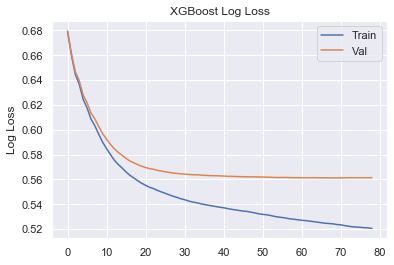

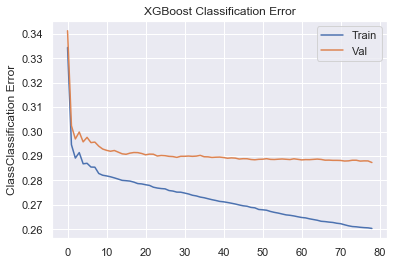

In [1725]:
results = NDF_clf.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Val')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()
# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Val')
ax.legend()
plt.ylabel('ClassClassification Error')
plt.title('XGBoost Classification Error')
plt.show()

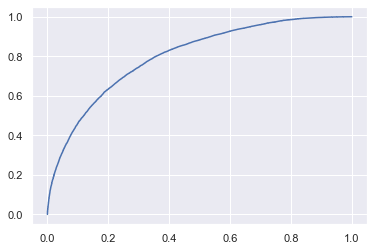

In [1777]:
probs = NDF_clf.predict_proba(X_val)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_val, preds)
#roc_auc = auc(fpr, tpr)
roc_auc = roc_auc_score(y_val, preds)
plt.plot(fpr, tpr, 'b', label = 'XGBoost Test AUC = %0.3f' % roc_auc)

### US_clf

In [1819]:
US_train = train[train['label'] != 'NDF']
US_train = US_train.reset_index(drop=True)
US_label = US_train['label']

In [1820]:
bi_labels = []
for i in range(len(US_label)):
    if US_label[i] == 'US':
        bi_labels.append('US')
    else:
        bi_labels.append('other')

In [1821]:
lableE_US = LabelEncoder()
y_train = lableE_US.fit_transform(bi_labels)

In [1822]:
X_train, X_val, y_train, y_val = train_test_split(US_train.iloc[:,:-1].values, y_train, test_size=0.2)

In [1730]:
US_clf = XGBClassifier(max_depth=9, learning_rate=0.1, n_estimators=100,
                    objective='binary:logistic', subsample=0.6, colsample_bytree=0.6, seed=0)   

In [1731]:
US_clf.fit(X_train, y_train, eval_metric=["error","logloss"], early_stopping_rounds=10, eval_set=[(X_train, y_train),(X_val,y_val)], verbose=True)

[0]	validation_0-error:0.297585	validation_0-logloss:0.676243	validation_1-error:0.306321	validation_1-logloss:0.677395
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 10 rounds.
[1]	validation_0-error:0.294098	validation_0-logloss:0.661707	validation_1-error:0.302384	validation_1-logloss:0.664192
[2]	validation_0-error:0.293746	validation_0-logloss:0.649506	validation_1-error:0.300866	validation_1-logloss:0.653183
[3]	validation_0-error:0.293226	validation_0-logloss:0.639227	validation_1-error:0.300866	validation_1-logloss:0.644366
[4]	validation_0-error:0.2931	validation_0-logloss:0.630577	validation_1-error:0.300247	validation_1-logloss:0.637067
[5]	validation_0-error:0.29272	validation_0-logloss:0.623051	validation_1-error:0.299629	validation_1-logloss:0.630953
[6]	validation_0-error:0.293086	validation_0-logloss:0.617045	validation_1-error:0.29991	validation_1-logloss:0.625986

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0,
              silent=None, subsample=0.6, verbosity=1)

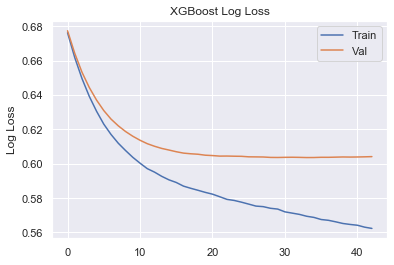

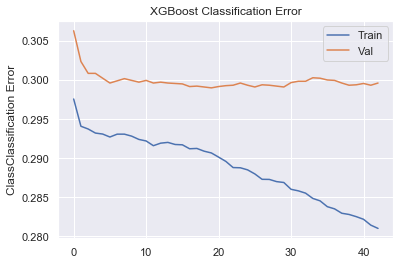

In [1732]:
results = US_clf.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Val')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()
# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Val')
ax.legend()
plt.ylabel('ClassClassification Error')
plt.title('XGBoost Classification Error')
plt.show()

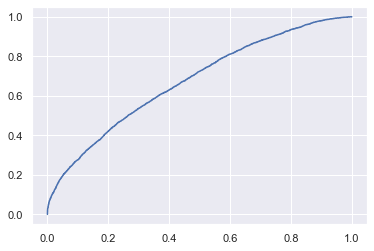

In [1782]:
probs = US_clf.predict_proba(X_val)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_val, preds)
#roc_auc = auc(fpr, tpr)
roc_auc = roc_auc_score(y_val, preds)
plt.plot(fpr, tpr, 'b', label = 'XGBoost Test AUC = %0.3f' % roc_auc)

## 5country_clf

In [1823]:
five_train = train[train['label'].isin(['FR','IT','GB','ES','CA'])]
five_train = five_train.reset_index(drop=True)
five_label = five_train['label']

In [1824]:
lableE_five = LabelEncoder()
y_train = lableE_five.fit_transform(five_label)

In [1825]:
X_train, X_val, y_train, y_val = train_test_split(five_train.iloc[:,:-1].values, y_train, test_size=0.2)

In [1736]:
five_clf = XGBClassifier(max_depth=12, learning_rate=0.05, n_estimators=500,
                    objective='"multi:softprob"', subsample=1, colsample_bytree=0.6, seed=1)   

In [1737]:
five_clf.fit(X_train, y_train, eval_metric=["merror","mlogloss"], early_stopping_rounds=10, eval_set=[(X_train, y_train),(X_val,y_val)], verbose=True)

[0]	validation_0-merror:0.521963	validation_0-mlogloss:1.59207	validation_1-merror:0.665945	validation_1-mlogloss:1.60343
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 10 rounds.
[1]	validation_0-merror:0.473979	validation_0-mlogloss:1.57438	validation_1-merror:0.663059	validation_1-mlogloss:1.59803
[2]	validation_0-merror:0.45143	validation_0-mlogloss:1.55623	validation_1-merror:0.654762	validation_1-mlogloss:1.59279
[3]	validation_0-merror:0.446649	validation_0-mlogloss:1.53924	validation_1-merror:0.649711	validation_1-mlogloss:1.58803
[4]	validation_0-merror:0.437359	validation_0-mlogloss:1.52249	validation_1-merror:0.64899	validation_1-mlogloss:1.58319
[5]	validation_0-merror:0.433751	validation_0-mlogloss:1.50774	validation_1-merror:0.647547	validation_1-mlogloss:1.57887
[6]	validation_0-merror:0.436818	validation_0-mlogloss:1.49385	validation_1-merror:0.64899	validation_1

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=12,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1,
              silent=None, subsample=1, verbosity=1)

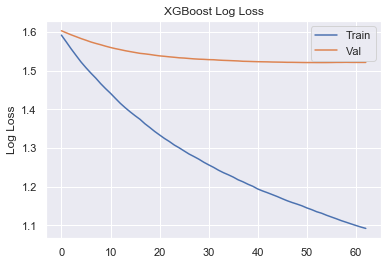

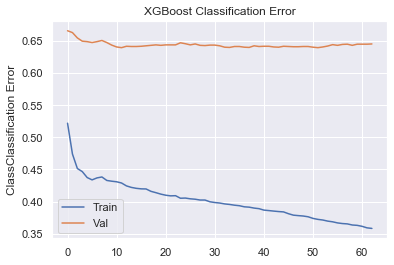

In [1738]:
results = five_clf.evals_result()
epochs = len(results['validation_0']['merror'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Val')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()
# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Val')
ax.legend()
plt.ylabel('ClassClassification Error')
plt.title('XGBoost Classification Error')
plt.show()

## 預測結果NDF-US-other

#### NDF_clf先預測,錯的再跑US_clf

NDF

In [1740]:
#change threshold
result_proba = NDF_clf.predict_proba(X_test)
ndf_pred= [1 if i > 0.6 else 0 for i in result_proba[:,1]]

In [1826]:
# load the model from disk
NDF_clf14 = pickle.load(open('NDF_clf.sav', 'rb'))
result_proba = NDF_clf14.predict_proba(X_test)
ndf_pred= [1 if i > 0.6 else 0 for i in result_proba[:,1]]

US

In [1827]:
#change threshold
result_proba = US_clf.predict_proba(X_test)
us_pred= [1 if i > 0.63 else 0 for i in result_proba[:,1]]

最後五個

In [1828]:
result_proba = five_clf.predict_proba(X_test)

In [1829]:
result_proba

array([[0.08814256, 0.16910368, 0.29962945, 0.1715328 , 0.27159148],
       [0.10496449, 0.18810023, 0.31859806, 0.18130559, 0.20703165],
       [0.13051486, 0.21847245, 0.31324846, 0.18539648, 0.15236771],
       ...,
       [0.10227244, 0.23754221, 0.40699637, 0.08668929, 0.16649967],
       [0.06559543, 0.08662731, 0.3729825 , 0.17972633, 0.29506844],
       [0.1626917 , 0.18771045, 0.24065192, 0.14231087, 0.26663503]],
      dtype=float32)

輸出答案

In [1830]:
ndf_ans = lableE_NDF.inverse_transform(ndf_pred)
us_ans = lableE_US.inverse_transform(us_pred)

In [1831]:
y_pred = five_clf.predict(X_test)

In [1832]:
five_ans=[]
for i in tqdm_notebook(range(len(y_pred))):
    a = list(lableE_five.inverse_transform(np.argsort(result_proba[i])))
    a.reverse()
    five_ans += a[:2]

In [1833]:
ans = []
for i in range(len(test_id)):
    if ndf_ans[i] == 'NDF':
        ans.append('NDF')
        ans.append(us_ans[i])
        if us_ans[i] == 'US':
            ans.append('other')
        else:
            ans.append('US')
    else:
        ans.append(us_ans[i])
        ans.append('NDF')
        if us_ans[i] == 'US':
            ans.append('other')
        else:
            ans.append('US')
    ans.append(five_ans[i*2])
    ans.append(five_ans[i*2+1])

In [1834]:
df=pd.DataFrame({'id':np.repeat(test_id,5),'country':ans})

In [1835]:
df.to_csv('five_submission14.csv',index=False)

In [1485]:
df['sort'] = [1,2,3]*62096

In [1491]:
df[df['sort'] == 1]['country'].value_counts()

NDF    48248
US     13848
Name: country, dtype: int64

正常預測五個

In [993]:
train_d = all_data.values
X_train = train_d[:length]
X_test = train_d[length:]

In [994]:
lableE = LabelEncoder()
y_train = lableE.fit_transform(labels)

In [995]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [996]:
clf = XGBClassifier(max_depth=9, learning_rate=0.1, n_estimators=100,
                    objective='multi:softprob', subsample=1, colsample_bytree=0.6, seed=1) 

In [ ]:
clf.fit(X_train, y_train, eval_metric=["merror","mlogloss"], early_stopping_rounds=10, eval_set=[(X_train, y_train),(X_val,y_val)], verbose=True)

In [ ]:
results = clf.evals_result()
epochs = len(results['validation_0']['merror'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Val')
ax.legend()
plt.ylabel('Multi-Class Log Loss')
plt.title('XGBoost Log Loss')
plt.show()
# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Val')
ax.legend()
plt.ylabel('Multi-ClassClassification Error')
plt.title('XGBoost Classification Error')
plt.show()

In [ ]:
clf.score(X_val,y_val)

In [ ]:
y_pred = clf.predict_proba(X_test)

In [ ]:
df=pd.DataFrame({'id':[],'country':[]})
a1=[]
t_id1 = []
for i in tqdm_notebook(range(len(y_pred))):
    t_id = [test_id[i]]*5
    a = list(lableE.inverse_transform(np.argsort(y_pred[i])))[:7]
    a.reverse()
    a1 = a1+a
    t_id1 = t_id1+t_id
df2 = pd.DataFrame(np.array([t_id1, a1]).T, columns=['id','country'])
df = df.append(df2)

用答案比例來排序後直接丟進去

In [1154]:
ans = ['NDF','US','other','FR','IT']
ans = ['NDF','US']

In [1155]:
df=pd.DataFrame({'id':np.repeat(test_id,2),'country':ans*len(test_id)})

In [1156]:
df.to_csv('submission.csv',index=False)

In [565]:
# replace feature to other by percentage
def replace_f(df,columns,threshold):
    dict_={}
    for i,j in dict(df[columns].value_counts()/len(df)).items():
        if i=='craigslist':
            dict_[i]=i
        elif j > threshold:
            dict_[i]=i
        else:
            dict_[i]='other'
    df[columns] = df[columns].map(dict_)

#affiliate_channel

replace_f(train,'affiliate_channel',0.04)

replace_f(test,'affiliate_channel',0.01)

#affiliate_provider

replace_f(train,'affiliate_provider',0.01)

replace_f(test,'affiliate_provider',0.01)

#first_browser

replace_f(train,'first_browser',0.01)

replace_f(test,'first_browser',0.04)

#language

replace_f(train,'language',0.001)

replace_f(test,'language',0.001)

#signup_method

test['signup_method'] = test['signup_method'].replace('weibo','basic')

In [1752]:
best = pd.read_csv("five_submission.csv")

In [1753]:
best['sort'] = [1,2,3,4,5]*62096

In [1754]:
df['sort'] = [1,2,3,4,5]*62096

In [1758]:
df[df['sort'] ==1]['country'].value_counts()

NDF      48278
US       13815
other        3
Name: country, dtype: int64

In [1756]:
best['my'] = list(df['country'])

In [1757]:
best[best['country'] != best['my']][best['sort'] == 1]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,id,country,sort,my
55,fyomoivygn,US,1,NDF
100,rddbczuxx1,NDF,1,US
125,ovc6nwn6mj,US,1,NDF
185,xp1zfu6j6u,US,1,NDF
225,p2l7d6qu1u,US,1,NDF
260,6n6tybnvcx,NDF,1,US
280,mqinin79lg,US,1,NDF
335,mzf3jtgyaz,NDF,1,US
370,h7m6kvw83d,US,1,NDF
375,v08shve4h2,US,1,NDF
